In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

import cleaning_fun as cfun
cle = cfun.cleaner()

%reload_ext autoreload
%autoreload 2

In [2]:
data1 = pd.read_csv(".\\data\\data1.csv")

# "abb14" () is droped due to their NaN values
data1 = data1.drop(["Unnamed: 0", "abb14"], axis = 1)
# Fill missing values in "last entrance" with subscription purchase date.
# This because all IDs that do not have a last entrance, actually never used the card (check below)
data1["ultimo_ing.x"] = data1["ultimo_ing.x"].fillna(data1["abb13"])

# Add a column that is the interval between last entrance date and subscription purchase date.
# It may be useful because this time window identifies those that can be really interested in museums
# (e.g. small span -> used the card immediately because of immediate purchase, then forgot about it)
data1["span.utilizzo"] = data1.apply(lambda row: (pd.to_datetime(row["ultimo_ing.x"]) -
                                                  pd.to_datetime(row["abb13"])).days,
                                     axis = 1)

# Convert the target variable to categorical
data1["si2014"] = pd.Categorical(data1["si2014"])
data1.head()

,codcliente,si2014,ultimo_ing.x,abb13,span.utilizzo
0,100005,0,2013-09-19,2013-01-27,235
1,100006,1,2013-11-21,2013-01-14,311
2,100007,0,2012-12-05,2012-12-05,0
3,100017,1,2013-10-19,2012-12-10,313
4,100020,0,2013-08-11,2012-12-09,245


To check whether there were IDs who entered in a museum (`in13`) that had `NaN` values in the `data1["ultimo_ing.x"]` dataframe
```python
[x for x in in13cus["codcliente"].unique() if x in data1[data1["ultimo_ing.x"].isna()]["codcliente"].unique()]
```

-----------

In [3]:
an13 = pd.read_csv(".\\data\\an13.csv", na_values = "NA", encoding = "latin1")

# "CAP", "agenzia", "riduzione" & "sconto" have to many values to actually be useful.
# "Professione" has 100% NaN values
an13 = an13.drop(["Unnamed: 0", "professione", "sconto",
                  "riduzione", "agenzia", "cap"], axis = 1)

# Convert "data di nascita" into age at the end of year 2013.
# Before, it was necessary to replace 2 values that had "-" with
# the median of the overall year of birth distribution (= 1959).
an13["data_nascita"] = an13["data_nascita"].apply(lambda v: np.nan if "-" in v else int(v))
an13["data_nascita"] = an13["data_nascita"].fillna(an13["data_nascita"].median())
an13["age"] = 2013 - an13["data_nascita"]

# "nuovo_abb" is alrady dichotomous and with full values. Just convert it into 0/1
an13["nuovo_abb"] = pd.Categorical(an13["nuovo_abb"].apply(lambda x: 1 if x == "NUOVO ABBONATO"
                                                           else 0))

# "sesso" has missing values. We filled the according to the distribution of non-NaN values
count_sex = an13["sesso"].value_counts(normalize=True)
missing_sex = an13["sesso"].isnull()
an13.loc[an13["sesso"].isnull(), "sesso"] = np.random.choice(count_sex.index,
                                                             size = len(an13[missing_sex]),
                                                             p = count_sex.values)

# Then the 0/1 variable is created according to sex (female = 1)
an13["femmina"] = pd.Categorical(an13["sesso"].apply(lambda x: 1 if x == "F" else 0))

# Tipo_pag is converted into 4 dummies
an13 = pd.concat([an13, pd.get_dummies(an13["tipo_pag"], drop_first = True)], axis = 1)

# The following columns will then be converted into categories
an13["BANCOMAT"] = pd.Categorical(an13["BANCOMAT"])
an13["CONTANTI"] = pd.Categorical(an13["CONTANTI"])
an13["CARTA DI CREDITO"] = pd.Categorical(an13["CARTA DI CREDITO"])
an13["NESSUN PAGAMENTO"] = pd.Categorical(an13["NESSUN PAGAMENTO"])

an13 = an13.drop(["sesso","tipo_pag","data_nascita"], axis = 1)

In [4]:
# The following dataset, created from a .json file, is needed to
# reduce the dimensionality of the column "comune".
comunes = pd.read_csv(".\\data\\comuni_done.csv", sep = ";")
comunes = comunes.drop(["Unnamed: 0", "codice","zona__codice","zona__nome",
                        "regione__codice","regione__nome","provincia__codice",
                        "provincia__nome", "codiceCatastale","CAP", "popolazione"], axis = 1)
comunes["nome"] = comunes["nome"].str.upper()
comunes = comunes.rename({"nome": "comune"}, axis = 1)

# We performed a merge on the column "comune" of an13 dataframe,
# then we adjusted the result by creating a dictionary with the unmatched
# values of that column (mainly foregn countries).
an13 = an13.merge(comunes, how = "left", on = "comune")

# The following column is to replace NaN values of "sigla" according to the
# dictionary above, and eventually to reduce its dimensionality to 3
an13["sigla"] = cle.provs(an13)

# From the updated column "sigla" it was possible to create
# the dummies and attached them on the right side of an13.
an13 = pd.concat([an13, pd.get_dummies(an13["sigla"], drop_first = True)], axis = 1)


# Finally, the last column whose dimensionality needed a reduction was 
# "agenzia_tipo", that was broken down into 5 aspects based on conceptual
# clusters of the original values. Then the column is added to "an13" and dropped
an13["agenzia_tipo"] = cle.reduce_agency(an13)
an13 = pd.concat([an13, pd.get_dummies(an13["agenzia_tipo"], drop_first = True)], axis = 1)

# At last, we created the column of the day of the year
# in which a customer purchased their subscription.
an13["data_inizio"] = pd.to_datetime(an13["data_inizio"], format = "%d/%m/%Y %H:%M")
an13["day_y_purchase"] = [int(x.strftime('%j')) for x in an13["data_inizio"]]

an13 = an13.drop(["comune","sigla", "data_inizio", "agenzia_tipo"], axis = 1)

an13 = an13.rename(columns = {"importo": "prezzo_card"})

# Convert the dummies created into categorical variables
for c in an13.columns[9:15]:
    an13[c] = pd.Categorical(an13[c])

an13.head()

,codcliente,prezzo_card,nuovo_abb,age,femmina,BANCOMAT,CARTA DI CREDITO,CONTANTI,NESSUN PAGAMENTO,PI,TO,CRAL/TESSERE ORO/ASSOCIAZIONE,MUSEO/TEATRI/EDICOLE,OFFERTE/GRUPPI,PUNTO INFORMATIVO/COMMERCIALE/NAN,day_y_purchase
0,90095,28,1,28.0,0,0,0,1,0,0,1,0,0,0,1,344
1,89662,28,1,28.0,0,0,0,1,0,0,1,0,0,0,1,6
2,202278,28,1,21.0,0,1,0,0,0,0,1,0,0,0,1,27
3,269895,28,1,27.0,0,0,0,1,0,0,0,0,0,0,1,337
4,88177,28,1,30.0,0,0,0,1,0,0,1,0,0,0,1,26


------------------

In [5]:
in13 = pd.read_csv(".\\data\\in13.csv", na_values = "NA")
in13 = in13.drop("Unnamed: 0", axis = 1)
# The rename will be useful in the merge of the 3 final datasets,
# while the following line is a quick string cleaning
in13 = in13.rename(columns = {"CodCliente": "codcliente"})
in13["museo"] = [x.replace("\\","").replace('"',"") for x in in13["museo"]]

# Merge with a file that contains the type of museum per each line
un_mus = pd.read_excel(".\\data\\museums.xlsx")
un_mus["museo"] = [x.replace("\\","").replace('"',"") for x in un_mus["museo"]]
in13 = in13.merge(un_mus, how = "left", on = "museo")

# Drop (actually exclude) all the rows that contain the weird "00:00" value
in13 = in13[in13['orai'] != "00:00"]

# Collapse into one column the date and time of entrance, so the timestamp is precise and unique
in13["timestamp"] = pd.to_datetime(in13["datai"] + " " + in13["orai"],
                                   format = "%d/%m/%Y %H:%M")

# Drop "day_entrance" & "time_entrance"
in13 = in13.drop(["datai", "orai", "comune.museo","prov.museo"], axis = 1)

# Order the dataset by the timestamp
in13 = in13.sort_values(by = ["timestamp"], ignore_index = True)

# Apply the function in the class
in13 = cle.company(in13)
in13.head()

,importo,museo,prov_museo,com_museo,codcliente,tipo.museo,timestamp,compagnia
0,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia,2012-12-01 10:10:00,1.0
1,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia,2012-12-01 10:11:00,1.0
2,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia,2012-12-01 10:11:00,1.0
3,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia,2012-12-01 10:12:00,1.0
4,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,16834,Storia,2012-12-01 10:39:00,0.0


From `in13`, we've built a new dataframe with the following columns:
- *codcliente*
- *frequenza*: number of times every customer went to museums
- *variety*: how many different museums they have visited
- *tipo.passione*: the kind of museum in which each customer is more fond of
- *passione.score*: given different museum's categories, this score measures how many times a customer prefers a category. If they did only one visit, the score is set just below the `0.8` thershold
- *appassionato*: takes the "passione" scores into a dichotomous variable at a `0.8` threshold. The result is that only `20%` of the customer is defined as passionate, which may be closed to reality
- *compagnia*: takes the average of the values in in13, then at a 0.5 threshold, the variable is converted to dichotomous

In [57]:
in13cus = in13.pivot_table(index = "codcliente",
                           values = ["importo", "com_museo", "museo", "tipo.museo", "compagnia"],
                           aggfunc = {"importo": np.nansum, "com_museo": "count",
                                      "museo": pd.Series.nunique,
                                      "tipo.museo": (lambda x: stats.mode(x).count[0]),
                                      "compagnia": np.nanmean})

pivot_mode = in13.pivot_table(index = "codcliente", values = "tipo.museo",
                               aggfunc = (lambda x: stats.mode(x).mode[0]))
pivot_mode = pivot_mode.rename(columns = {"tipo.museo": "tipo.passione"})
in13cus = in13cus.join(pivot_mode)

in13cus = in13cus.rename(columns = {"importo":"importo_tot", "com_museo":"frequenza",
                                    "museo": "variety"}).reset_index()
in13cus["passione.score"] = in13cus["tipo.museo"]/in13cus["frequenza"]

in13cus.loc[in13cus["frequenza"] == 1, "passione.score"] = 0.1

in13cus["appassionato"] = in13cus.apply(lambda row: "Non.appassionato"
                                        if row["passione.score"] < 0.8
                                        else row["tipo.passione"], axis = 1)

in13cus["compagnia"] = pd.Categorical(in13cus["compagnia"].apply(lambda x: 1
                                                                 if x > 0.5 else 0) )

in13cus = in13cus[["codcliente", "frequenza", "importo_tot",
                   "variety", "compagnia", "appassionato"]]

in13cus = pd.concat([in13cus.drop("appassionato", axis = 1),
                     pd.get_dummies(in13cus["appassionato"],
                                    drop_first = True)], axis = 1)

for c in in13cus.columns[4:]:
    in13cus[c] = pd.Categorical(in13cus[c])
    
in13cus.head()

,codcliente,frequenza,importo_tot,variety,compagnia,Arte,Non.appassionato,Parco,Scienze,Sport,Storia
0,6,2,8.60,2,0,0,1,0,0,0,0
1,13,9,33.50,7,1,0,1,0,0,0,0
2,16,6,25.75,6,0,0,1,0,0,0,0
3,23,2,9.25,2,1,0,1,0,0,0,0
4,27,1,5.00,1,0,0,1,0,0,0,0


In [60]:
# a = pd.DataFrame(dizionario {codcliente : cap})
# merge tra "in13cus" e "a" su "codcliente"
# così puoi abbinare la frequenza di visite di ogni cap

# per usare lo shapefile che abbiamo già, prima del merge selezionare
# solo i "nomi" che sono nelle e regioni del NO (regione__nome).
coms = pd.read_csv(".\\data\\comuni_done.csv", sep = ";")
in13bis = pd.read_csv(".\\data\\in13.csv", na_values = "NA")

-------------

In [61]:
print(data1.shape, an13.shape, in13cus.shape)

(80140, 5) (87072, 16) (77648, 11)


In [62]:
df0 = in13cus.merge(an13, on = "codcliente")
df = df0.merge(data1, on = "codcliente")
df.shape

(71504, 30)

In [63]:
print(round(len(data1[data1["si2014"] == 1])/len(data1)*100,2),"%")
print(round(len(df[df["si2014"] == 1])/len(df)*100,2),"%")

69.39 %
72.26 %


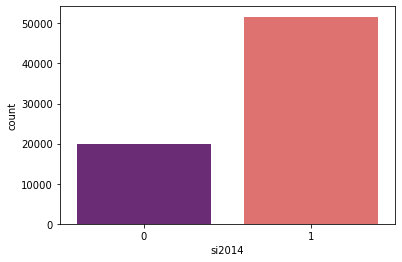

In [65]:
sns.countplot(x = df["si2014"], palette = "magma")
plt.show()

In [66]:
# CREATE NEW DATASET
df.to_csv(".\\data\\customer_data.csv")

# EDA

## Data 1

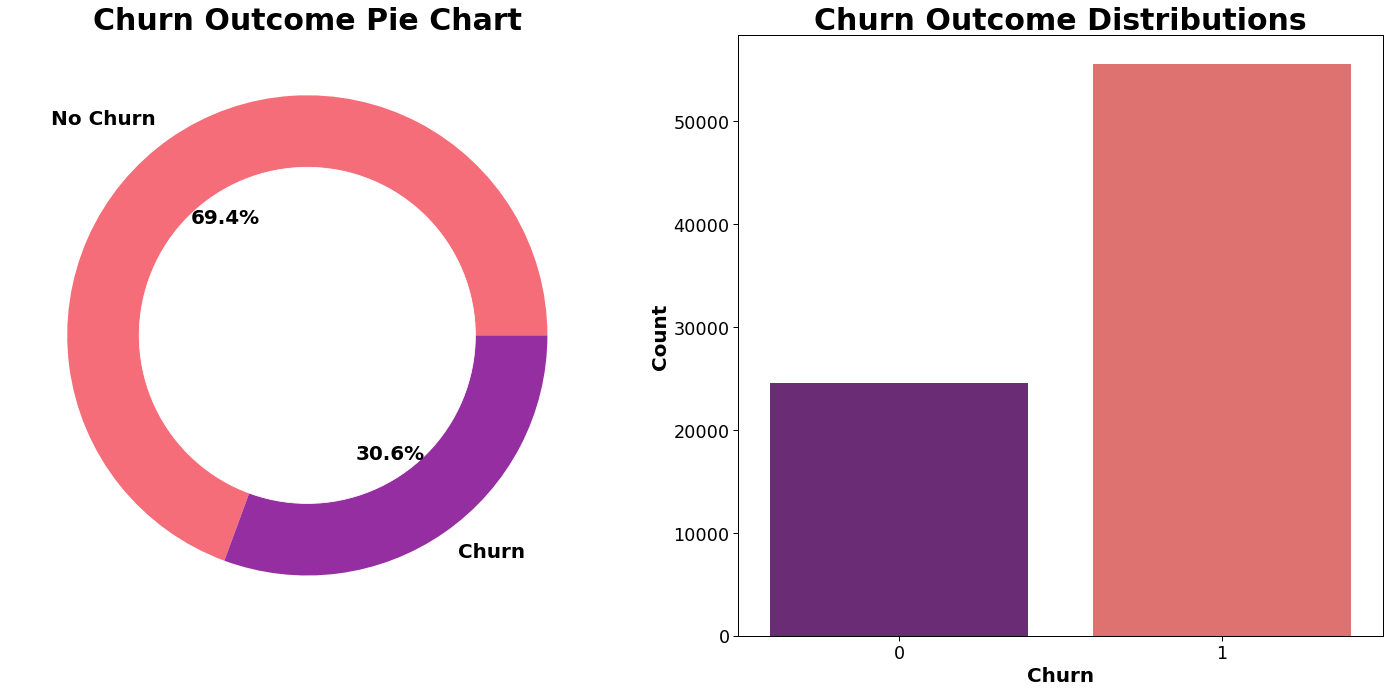

In [68]:
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.pie(data1["si2014"].value_counts(), labels = ['No Churn', 'Churn'], colors= ["#F66D7A","#952EA0"],
        autopct = '%.1f%%', radius = 1, textprops={'fontsize': 20, 'fontweight': 'bold'})
my_circle = plt.Circle( (0,0), 0.7, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Churn Outcome Pie Chart', fontsize = 30, fontweight = 'bold')
plt.subplot(122)
t = sns.countplot(x = data1["si2014"], palette = 'magma')
t.set_xlabel('Churn', fontweight = 'bold', fontsize = 20)
t.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Churn Outcome Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()
plt.savefig(".\\figures\\Data1_churn_distribution.jpg", dpi = 300)

## In13

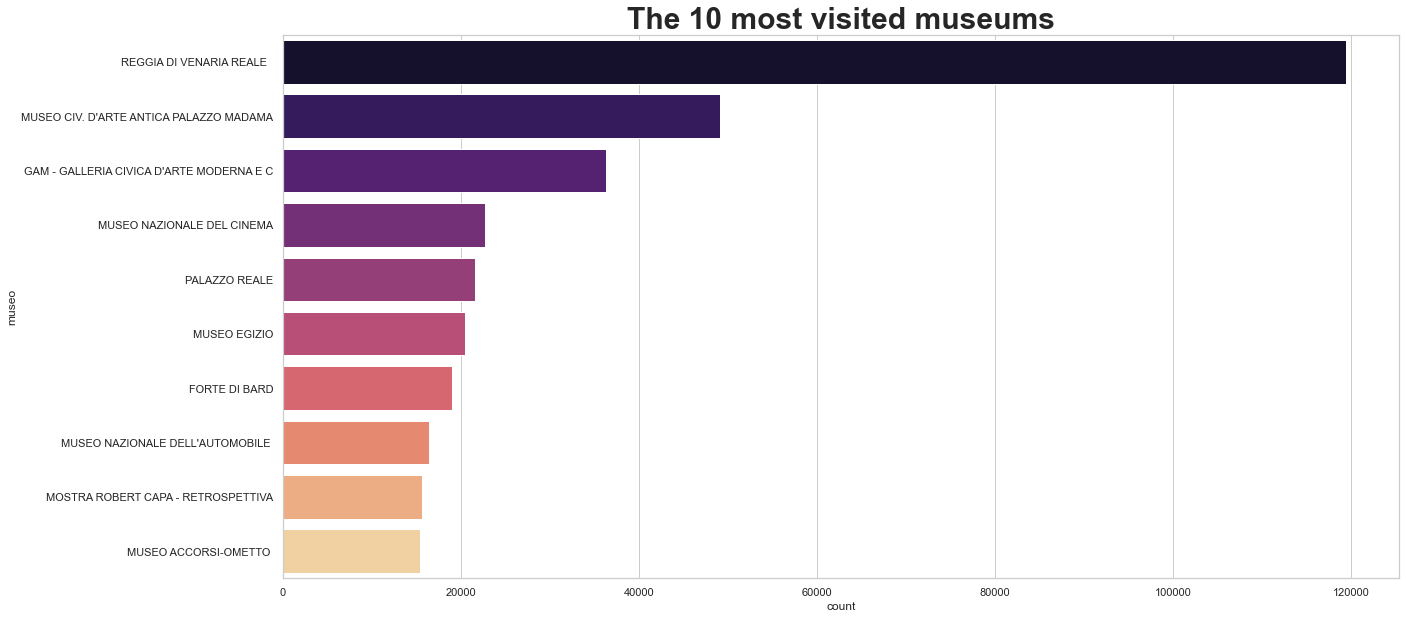

In [70]:
sns.set(style = 'whitegrid')
fig = plt.figure(figsize = (20, 10))
sns.countplot(y = "museo", data = in13, palette = "magma",
              order = in13["museo"].value_counts().iloc[:10].index)
plt.title('The 10 most visited museums', fontsize = 30, fontweight = 'bold')
plt.savefig(".\\figures\\In13_10_most_visited_museums.jpg", dpi = 300)

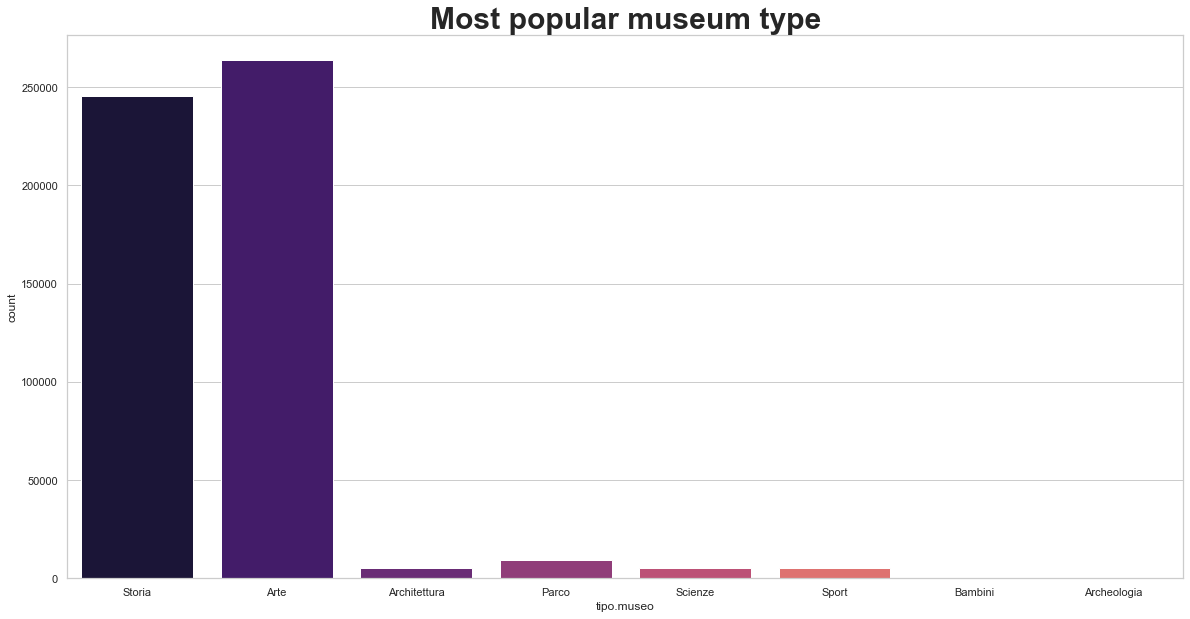

In [71]:
sns.set(style = 'whitegrid')
fig = plt.figure(figsize = (20, 10))

sns.countplot(x = in13["tipo.museo"], palette = "magma")
plt.title('Most popular museum type', fontsize = 30, fontweight = 'bold')
plt.savefig(".\\figures\\In13_Museums_type.jpg", dpi = 300)

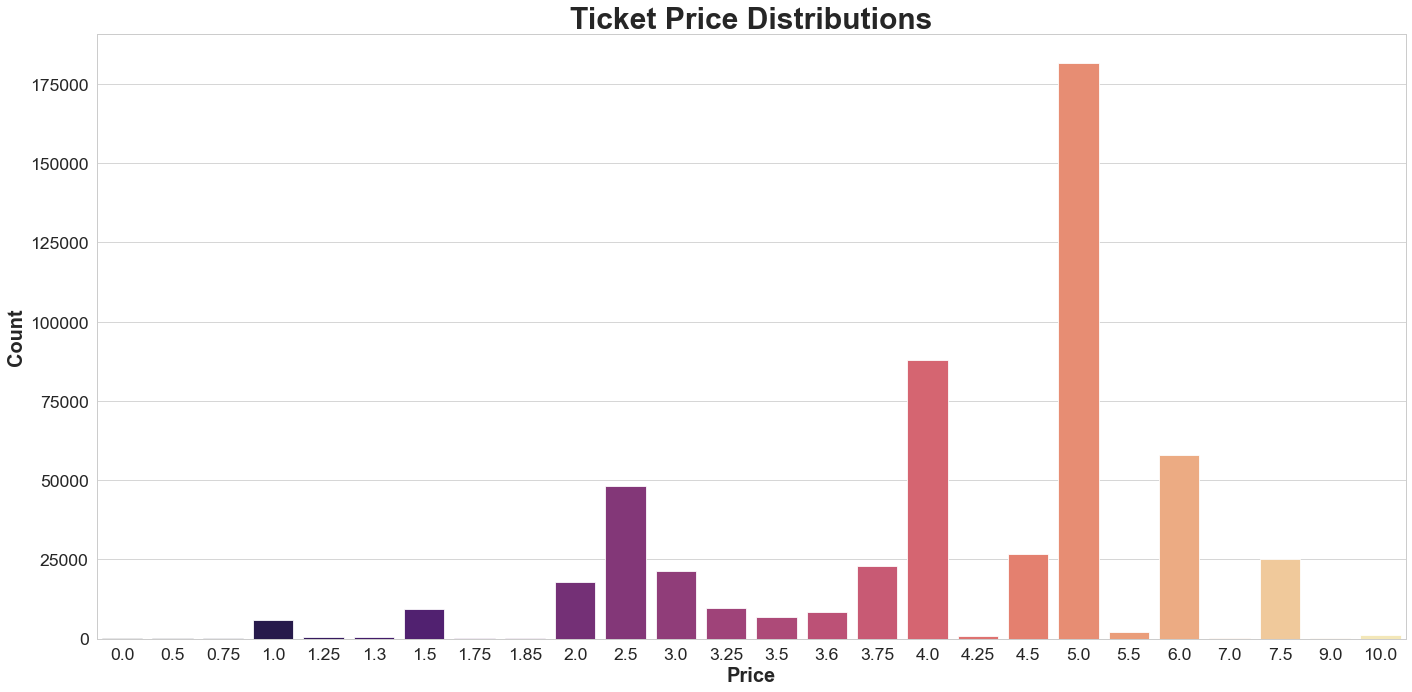

In [73]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
sns.color_palette("magma")
fig = plt.figure(figsize = (20, 10))
price = sns.countplot(x = in13["importo"], palette = 'magma')
price.set_xlabel('Price', fontweight = 'bold', fontsize = 20)
price.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Ticket Price Distributions', fontsize = 30, fontweight = 'bold')
plt.tight_layout()
plt.savefig(".\\figures\\In13_Ticket_Price_Distributions.jpg", dpi = 300)

In [74]:
in13bis = pd.read_csv(".\\data\\in13.csv", na_values = "NA")
in13bis = in13bis.drop("Unnamed: 0", axis = 1)
# The rename will be useful in the merge of the 3 final datasets,
# while the following line is a quick string cleaning
in13bis = in13bis.rename({"CodCliente": "codcliente"}, axis = 1)
in13bis["museo"] = [x.replace("\\","").replace('"',"") for x in in13bis["museo"]]

# Merge with a file that contains the type of museum per each line
un_musbis = pd.read_excel(".\\data\\museums.xlsx")
un_musbis["museo"] = [x.replace("\\", "").replace('"', "") for x in un_musbis["museo"]]
in13bis = in13bis.merge(un_musbis, how = "left", on = "museo")
in13bis = in13bis.drop(["comune.museo","prov.museo"], axis = 1)

# Drop (actually exclude) all the rows that contain the weird "00:00" value
in13bis = in13bis[in13bis['orai'] != "00:00"]

# Collapse into one column the date and time of entrance, so the timestamp is precise and unique
in13bis["timestamp"] = pd.to_datetime(in13bis["datai"] + " " + in13bis["orai"], format = "%d/%m/%Y %H:%M")

# Order the dataset by the timestamp
in13bis = in13bis.sort_values(by = ["timestamp"], ignore_index = True)

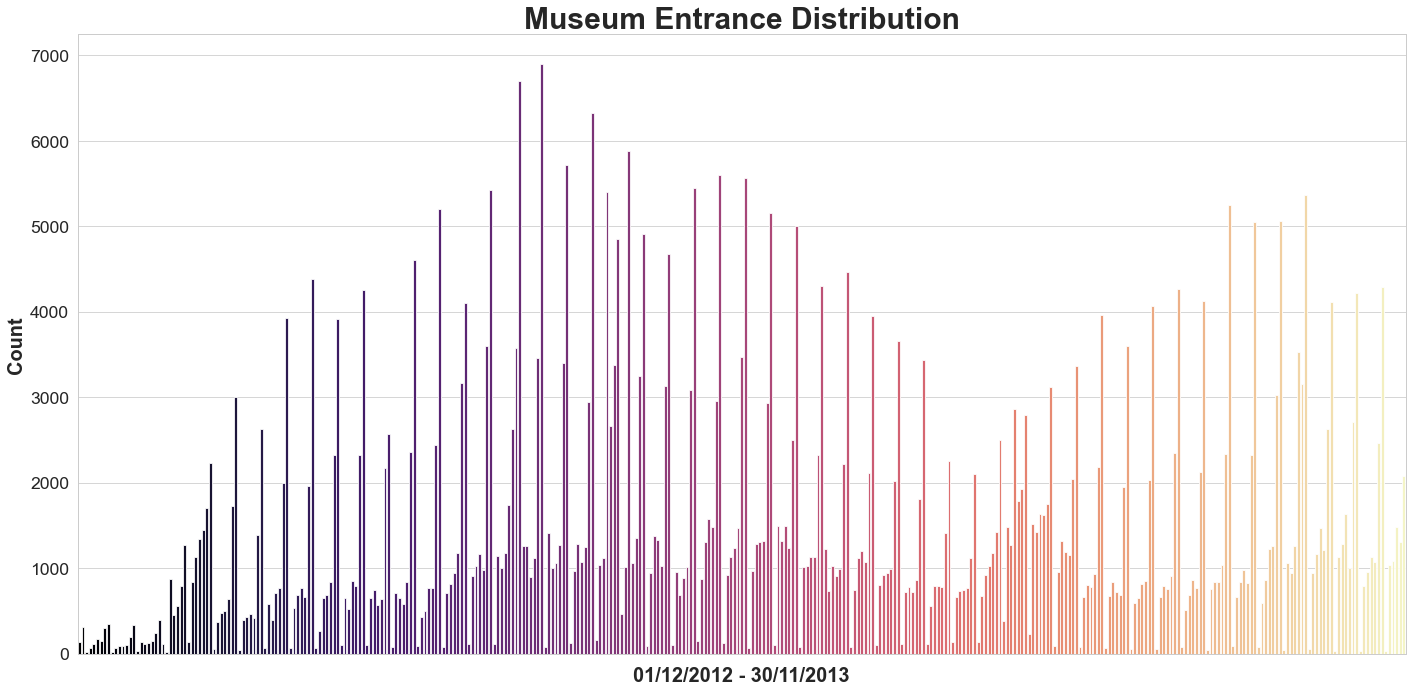

In [75]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
date = sns.countplot(x = in13bis["datai"], palette= 'magma')
date.set(xticklabels = [])
date.set_xlabel('01/12/2012 - 30/11/2013', fontweight = 'bold', fontsize = 20)
date.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Museum Entrance Distribution', fontsize = 30, fontweight = 'bold')
plt.tight_layout()
plt.savefig(".\\figures\\In13_Museum_Entrance_Distribution.jpg", dpi = 300)

## An13

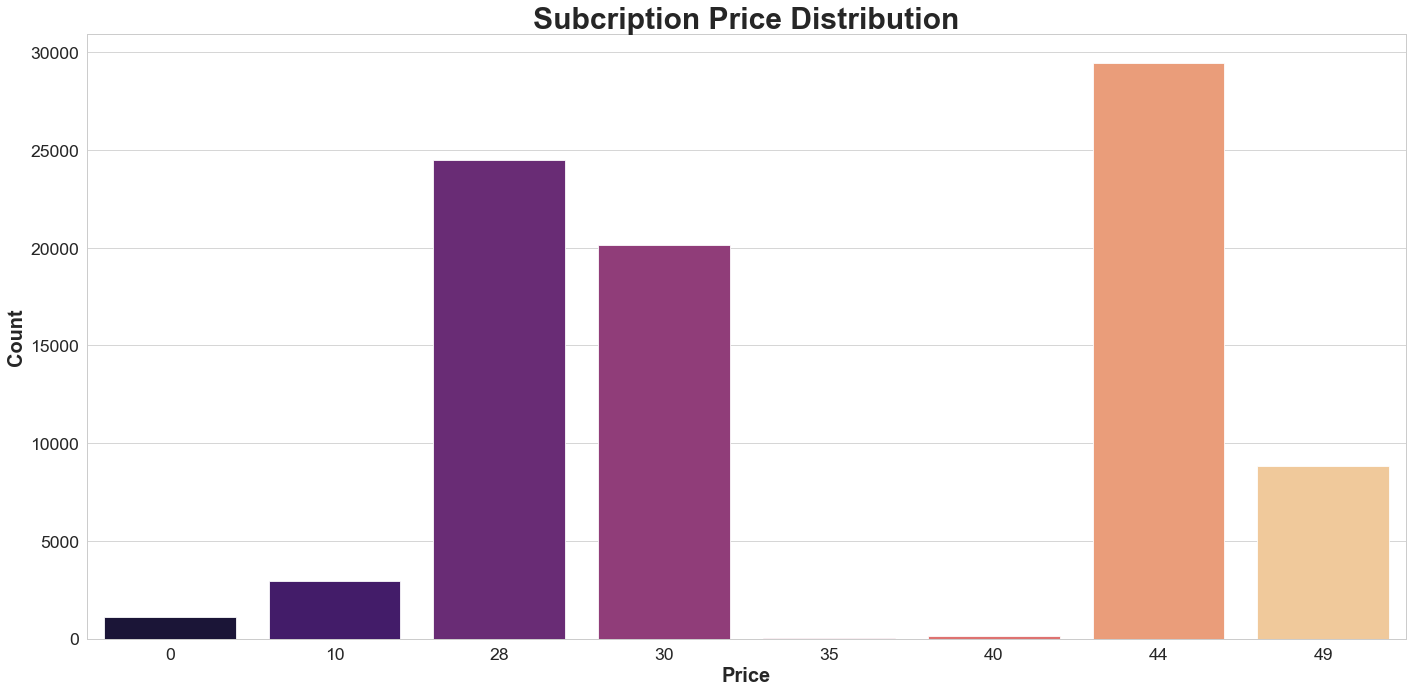

In [76]:
sns.set(style = 'whitegrid')
sns.set_context('paper', font_scale = 2)
sns.set_palette("magma")
fig = plt.figure(figsize = (20, 10))
price = sns.countplot(x = an13["prezzo_card"], palette = 'magma')
price.set_xlabel('Price', fontweight = 'bold', fontsize = 20)
price.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Subcription Price Distribution', fontsize = 30, fontweight = 'bold')
plt.tight_layout()
plt.savefig(".\\figures\\An13_Subcription_Price_Distribution.jpg", dpi = 300)

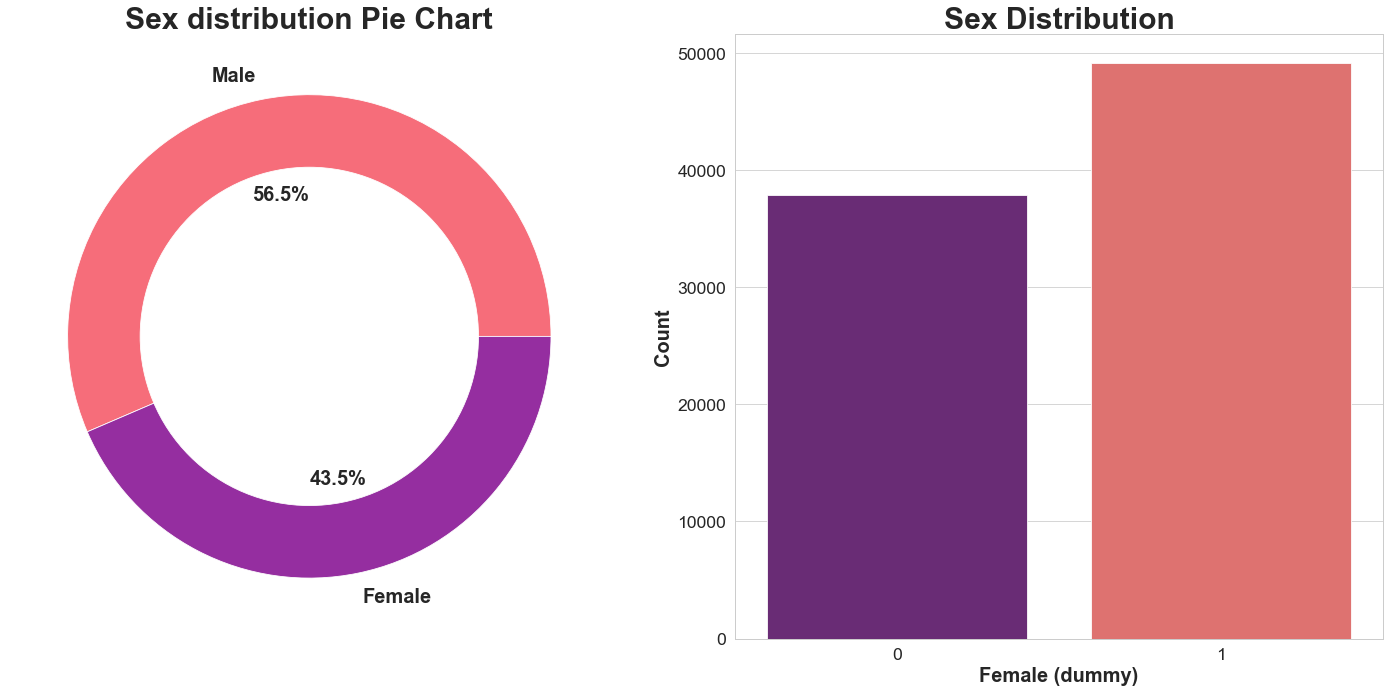

In [77]:
sns.set_context('paper', font_scale = 2)
fig = plt.figure(figsize = (20, 10))
plt.subplot(121)
plt.pie(an13["femmina"].value_counts(), labels = ['Male', 'Female'],
        colors = ["#F66D7A","#952EA0"],
        autopct = '%.1f%%', radius = 1,
        textprops = {'fontsize': 20, 'fontweight': 'bold'})
my_circle = plt.Circle( (0,0), 0.7, color = 'white')
q = plt.gcf()
q.gca().add_artist(my_circle)

plt.title('Sex distribution Pie Chart', fontsize = 30, fontweight = 'bold')
plt.subplot(122)
t2 = sns.countplot(x = an13["femmina"], palette = "magma")
t2.set_xlabel('Female (dummy)', fontweight = 'bold', fontsize = 20)
t2.set_ylabel('Count', fontweight = 'bold', fontsize = 20)
plt.title('Sex Distribution', fontsize = 30, fontweight = 'bold')
plt.tight_layout()
plt.savefig(".\\figures\\An13_Sex Distribution.jpg", dpi = 300)